<a href="https://colab.research.google.com/github/vedkhatri/COMM510_Coursework/blob/main/MOEA_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

from jMetalPy.jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jMetalPy.jmetal.algorithm.multiobjective.spea2 import SPEA2

from jMetalPy.jmetal.operator import SBXCrossover, PolynomialMutation
from jMetalPy.jmetal.problem.multiobjective.zdt import ZDT1, ZDT2, ZDT3, ZDT4, ZDT6
from jMetalPy.jmetal.problem.multiobjective.dtlz import DTLZ1, DTLZ2, DTLZ3, DTLZ4, DTLZ5, DTLZ6, DTLZ7
from jMetalPy.jmetal.util.termination_criterion import StoppingByEvaluations

from jMetalPy.jmetal.lab.visualization.plotting import Plot
from jMetalPy.jmetal.core.solution import FloatSolution
from jMetalPy.jmetal.util.solution import get_non_dominated_solutions
import matplotlib.pyplot as plt
import numpy as np

from jMetalPy.jmetal.core.quality_indicator import InvertedGenerationalDistance

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [61]:
p = get_problem('zdt1')
#ref_dirs = get_reference_directions('das-dennis', n_dim=3, n_partitions=13)
pareto = p.pareto_front()
print(pareto.shape)

(100, 2)


In [68]:
problem = ZDT1(number_of_variables=30)

max_evaluations = 16e3

algorithm1 = NSGAII(
    problem=problem,
    population_size=100,
    offspring_population_size=100,
    mutation=PolynomialMutation(probability= 1.0/30.0, distribution_index=20),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations)
)

algorithm2 = SPEA2(
    problem=problem,
    population_size=100,
    offspring_population_size=100,
    mutation=PolynomialMutation(probability= 1.0/30.0, distribution_index=20),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations)
)

algorithm1.run()
algorithm2.run()
solutions1 = algorithm1.get_result()
solutions2 = algorithm2.get_result()

[2023-07-11 17:35:14,700] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2023-07-11 17:35:14,705] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2023-07-11 17:35:14,706] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2023-07-11 17:35:14,707] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2023-07-11 17:35:18,609] [jmetal.core.algorithm] [DEBUG] Finished!
[2023-07-11 17:35:18,609] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2023-07-11 17:35:18,611] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2023-07-11 17:35:18,611] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2023-07-11 17:35:18,612] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2023-07-11 17:39:29,607] [jmetal.core.algorithm] [DEBUG] Finished!


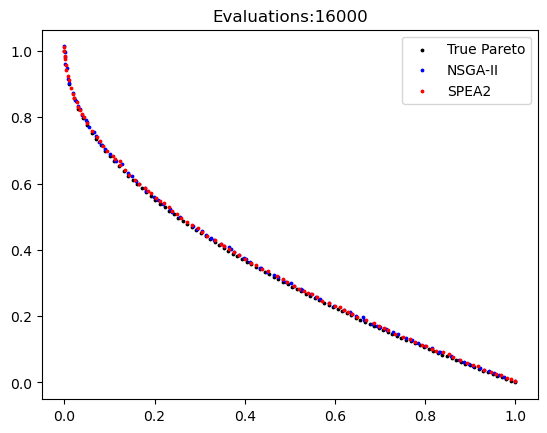

In [69]:
front1 = get_non_dominated_solutions(solutions1)
front2 = get_non_dominated_solutions(solutions2)

nsgaii_front = Plot.get_points(front1)
spea2_front = Plot.get_points(front2)

if len(nsgaii_front[0]) == 3:
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(*zip(*pareto), c='k', s=5, label='True Pareto')
    ax.scatter3D(*zip(*nsgaii_front), c='b', s=5, label='NSGA-II')
    ax.scatter3D(*zip(*spea2_front), c='r', s=5, label='SPEA2')

elif len(nsgaii_front[0]) == 2:
    plt.scatter(*zip(*pareto), c='k', s=3, label='True Pareto')
    plt.scatter(*zip(*nsgaii_front), c='b', s=3, label='NSGA-II')
    plt.scatter(*zip(*spea2_front), c='r', s=3, label='SPEA2')

plt.title(f'Evaluations:%d' %max_evaluations)
plt.legend()
plt.show()

In [54]:
#igd_pi = InvertedGenerationalDistance(front)
#soln = problem.evaluate(solutions)
#igd_pts = igd_pi.compute(soln)
print(len(nsgaii_front))
print(len(spea2_front))

99
100


In [38]:
from pymoo.indicators.igd import IGD

ind = IGD(pareto)

nsgaii_front = np.array(nsgaii_front)
spea2_front = np.array(spea2_front)

print("IGD [NSGA-II]:", ind(nsgaii_front))
print("IGD [SPEA2]:", ind(spea2_front))

IGD [NSGA-II]: 1.8704375527688775
IGD [SPEA2]: 1.7499577037717275


In [39]:
from scipy.spatial.distance import cdist
def delta_metric(algo_front, true_front):
    n = len(algo_front)
    distances = cdist(algo_front, true_front, metric='euclidean')
    closest_distances = np.min(distances, axis=1)
    df = np.min(closest_distances)
    dl = np.max(closest_distances)
    d_avg = np.mean(closest_distances)
    delta = (df + dl + np.sum(closest_distances - d_avg)) / (df + dl + (n - 1) * d_avg)
    return delta

nsgaii_front = np.array(nsgaii_front)
spea2_front = np.array(spea2_front)

delta1 = delta_metric(nsgaii_front, pareto)
delta2 = delta_metric(spea2_front, pareto)

print('Delta [NSGA-II]:', delta1)
print('Delta [SPEA2]:', delta2)

Delta [NSGA-II]: 0.10908112147270875
Delta [SPEA2]: 0.11574763855972894


In [34]:
from pymoo.indicators.hv import HV

nsgaii_front = np.array(nsgaii_front)
spea2_front = np.array(spea2_front)

if delta1 > delta2:
    ref_point = np.max(spea2_front, axis=0)
else:
    ref_point = np.max(nsgaii_front, axis=0)

ind = HV(ref_point=ref_point)

print('HV [NSGA-II]:', ind(nsgaii_front))
print('HV [SPEA2]:', ind(spea2_front))
print('True_HV', ind(np.array(pareto)))

HV [NSGA-II]: 0.5120264610402134
HV [SPEA2]: 0.6789113220682698
True_HV 0.7213987565051487
